In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import date, timedelta
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import spotpy
from scipy import stats

import cartopy.feature as cfeature
import numpy as np
import cartopy.crs as ccrs
import cartopy
import colorcet as cc
from cmcrameri import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import proplot as pplt

#warning
import warnings
warnings.filterwarnings('ignore')

d:\Miniconda3\envs\guteEnv\lib\site-packages\geopandas\_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1dev-CAPI-1.14.1) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
#############################################################
#os.chdir('D:/XanthosDev/Results_11072021/94')
#os.chdir('D:/XanthosDev/Results_11072021/Result_100k')
basinName = pd.read_csv('D:/XanthosDev/example/input/reference/BasinNames235.txt')
basin_id = pd.read_csv('D:/XanthosDev/example/input/reference/basin.csv')
#GRDC_xanthosCoordIndx = pd.read_csv('/project/hli/gabeshu/Guta_Working/Basins_Result/UScells/inputs/GRDC_xanthosCoordIndx.csv')
GRDC_xanthosCoordIndx = pd.read_csv('D:/XanthosDev/example/input/GRDC_stations_selected_final_list.csv')

indx_f = ~((GRDC_xanthosCoordIndx['basins']==58) | (GRDC_xanthosCoordIndx['basins']==84) | (GRDC_xanthosCoordIndx['basins']==169))
GRDC_xanthosCoordIndx = GRDC_xanthosCoordIndx[indx_f].reset_index(drop=True)

basins94 = np.array(GRDC_xanthosCoordIndx['basins']).astype(np.int64)
xanthosid = np.array(GRDC_xanthosCoordIndx['xanthosID_new_adj']).astype(np.int64)
basinName_94 = []
for ii in range(91):
    indx_basin = basins94[ii] - 1
    basinName_94.append(basinName['BName'][indx_basin])


In [3]:
#GRDC
grdc_basin_m3persec  =  pd.read_csv('D:/XanthosDev/example/input/calibration/grdc_95basin_m3persec_1971_1990_monthly.csv')
grdc_m3persec = np.zeros([91, 240])
for ii in range(91):   
    basin_num = basins94[ii]
    aa = (grdc_basin_m3persec['basin'] == basin_num)
    grdc_m3persec[ii,:] = np.array(grdc_basin_m3persec[aa]['q'])

In [4]:
def timeseries_coverter(data_array, start_yr, ending_yr):
    import numpy as np
    from datetime import date, timedelta
    sdate = date(start_yr,1,1)
    edate = date(ending_yr, 12, 31)  
    data_ts = pd.DataFrame(data_array)
    data_ts.index = pd.date_range(start=sdate, end=edate, freq='MS')

    return data_ts

## KGE : Calibration & Validation

In [5]:
grdc_basin_m3persec  =  pd.read_csv('D:/XanthosDev/example/input/calibration/grdc_95basin_m3persec_1971_1990_monthly.csv')
file_dir_watch_vald = 'D:\\XanthosDev\\Results-02-27-2022\\Simulated\\SimulatedFinal-v1\\flow\\'

###########################
kge_calval = np.zeros([91,3])
kge_calval[:,0] = basins94
for ii in range(91):
    basin_num = basins94[ii]    
    ## observed
    aa = (grdc_basin_m3persec['basin'] == basin_num)
    grdc_m3persec = np.array(grdc_basin_m3persec[aa]['q'])
    qobs_calibration= grdc_m3persec[0:120]
    qobs_validation = grdc_m3persec[120:240]    
    ## simulated
    data_basin = np.load(file_dir_watch_vald + 'SimFlow_' + str(basin_num) + '.npy')   
    qsim_calibration= data_basin[0:120]
    qsim_validation = data_basin[120:240]
    # KGE
    kge_calval[ii,1] = spotpy.objectivefunctions.kge(qobs_calibration, qsim_calibration) 
    kge_calval[ii,2] = spotpy.objectivefunctions.kge(qobs_validation, qsim_validation) 

kge_calval_df = pd.DataFrame(kge_calval)
kge_calval_df.columns = ['Basin','KGE-Calibration','KGE-Validation']

In [6]:
import datetime
grdc_basin_m3persec  =  pd.read_csv('D:/XanthosDev/example/input/calibration/grdc_95basin_m3persec_1971_1990_monthly.csv')
file_dir_watch_vald = 'D:\\XanthosDev\\Results-02-27-2022\\Simulated\\SimulatedFinal-HP\\flow\\'
file_dir_watch_natr = 'D:\\XanthosDev\\Results-02-27-2022\\Simulated\\SimulatedFinal-YL\\flow\\'

SAVE_KWDS = {"bbox_inches": "tight", "dpi": 450, "facecolor": "w"}
manual_selection = [0,7,4, 2,8,12]
kge_calval_regulated = np.zeros([91,3])
kge_calval_regulated[:,0] = basins94
kge_calval_natural = kge_calval_regulated.copy()
for jj in range(len(basins94)):
    basin_num = basins94[jj].astype(np.int32)    
    ## observed
    aa = (grdc_basin_m3persec['basin'] == basin_num)
    grdc_m3persec = np.array(grdc_basin_m3persec[aa]['q'])
    qobs_calibration= grdc_m3persec[0:120]
    qobs_validation = grdc_m3persec[120:240]    
    qobs_validation_ts = timeseries_coverter(qobs_validation, start_yr=1981, ending_yr=1990)

    ## simulated
    data_basin = np.load(file_dir_watch_vald + 'SimFlow_' + str(basin_num) + '.npy')   
    qsim_calibration= data_basin[0:120]
    qsim_validation = data_basin[120:240]
    qsim_validation_ts = timeseries_coverter(qsim_validation, start_yr=1981, ending_yr=1990)

    ## Natural
    data_basin_yl = np.load(file_dir_watch_natr + 'SimFlow_' + str(basin_num) + '.npy')   
    qsim_calibration_yl= data_basin_yl[0:120]
    qsim_validation_yl = data_basin_yl[120:240]
    qsim_validation_tsyl = timeseries_coverter(qsim_validation_yl, start_yr=1981, ending_yr=1990)
    

    # KGE : regulated
    kge_calr = spotpy.objectivefunctions.kge(qobs_calibration, qsim_calibration) 
    kge_valr = spotpy.objectivefunctions.kge(qobs_validation, qsim_validation) 
    kge_calval_regulated[jj,1] = kge_calr
    kge_calval_regulated[jj,2] = kge_valr
    # KGE : natural
    kge_caln = spotpy.objectivefunctions.kge(qobs_calibration, qsim_calibration_yl) 
    kge_valn = spotpy.objectivefunctions.kge(qobs_validation, qsim_validation_yl) 
    kge_calval_natural[jj,1] = kge_caln
    kge_calval_natural[jj,2] = kge_valn


kge_calval_regulated_dfx = pd.DataFrame(kge_calval_regulated)
kge_calval_regulated_dfx.columns = ['Basin','KGE-Calibration','KGE-Validation']  

kge_calval_natural_dfx = pd.DataFrame(kge_calval_natural)
kge_calval_natural_dfx.columns = ['Basin','KGE-Calibration','KGE-Validation']  


77
91
70
89


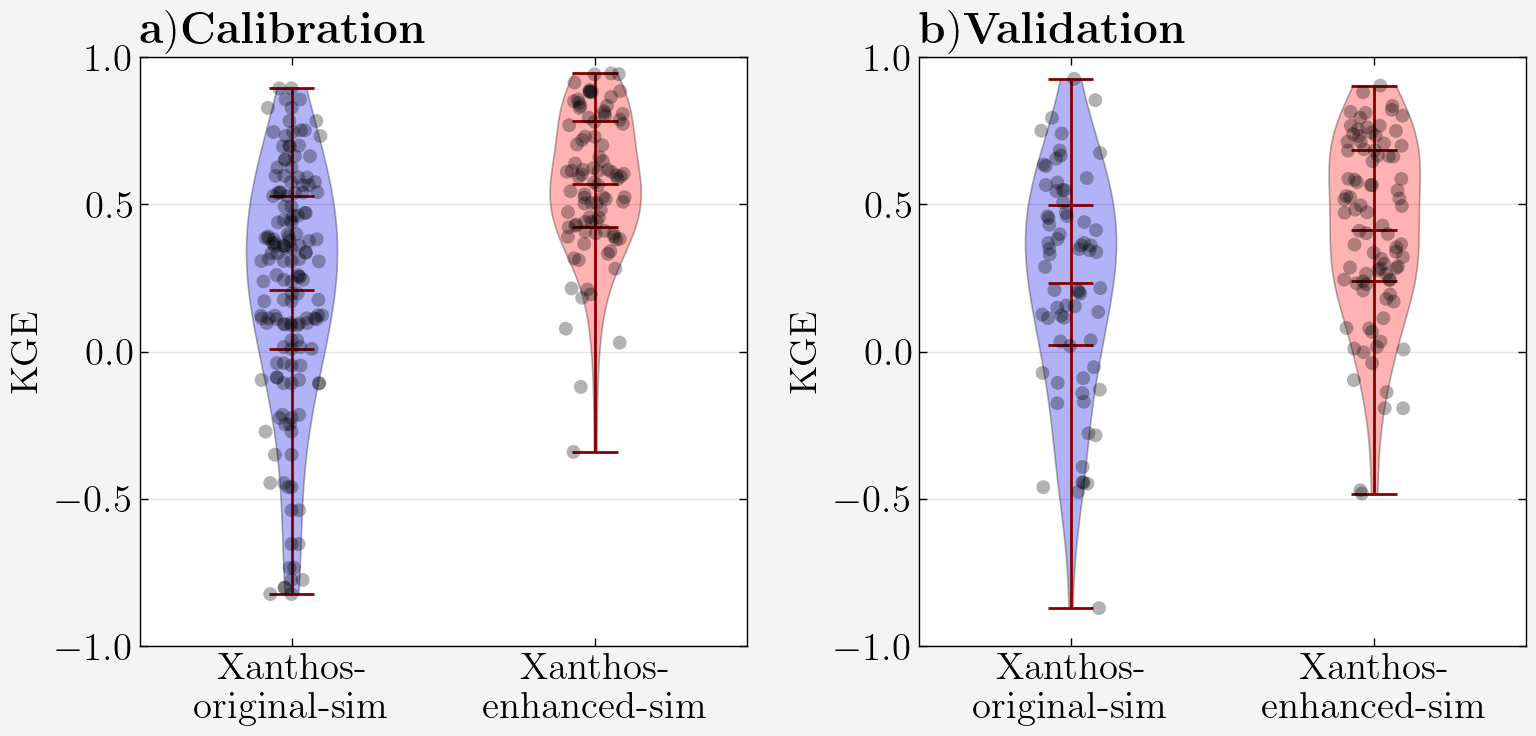

In [7]:
import cartopy.feature as cfeature
import numpy as np
import cartopy.crs as ccrs
import cartopy
import colorcet as cc
from cmcrameri import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import proplot as pplt
import xarray 
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from scipy.optimize import curve_fit
import seaborn as sb
plt.rcParams['figure.autolayout'] = True 
plt.rcParams.update({'font.size': 12}) 
import matplotlib.ticker as tck
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.autolayout'] = True 
plt.rcParams.update({'font.size': 14, 'font.weight':'bold'}) 

def violin_boxplot_colors(violin_plot):
    colors = ['dark red']
    ##cmaxes
    cbar_colors = violin_plot['cmaxes'].get_color()   
    violin_plot['cmaxes'].set_color(colors)
    ##cmins
    cbar_colors = violin_plot['cmins'].get_color()
    violin_plot['cmins'].set_color(colors)
    ##cmeans
    cbar_colors = violin_plot['cmeans'].get_color()
    violin_plot['cmeans'].set_color(colors)
    ##cbars
    cbar_colors = violin_plot['cbars'].get_color()
    violin_plot['cbars'].set_color(colors)
    ##cquantiles
    cbar_colors = violin_plot['cquantiles'].get_color()
    violin_plot['cquantiles'].set_color(colors)


plt.style.use('science')
with plt.style.context(['science', 'high-contrast']):
    #calib
    kge_calibration = pd.DataFrame()
    kge_calibration[['Basin','KGEnat']] = kge_calval_natural_dfx[['Basin',	'KGE-Calibration']]
    kge_calibration['KGEreg'] = kge_calval_regulated_dfx['KGE-Calibration']
    # valid
    kge_validation = pd.DataFrame()
    kge_validation[['Basin','KGEnat']] = kge_calval_natural_dfx[['Basin',	'KGE-Validation']]
    kge_validation['KGEreg'] = kge_calval_regulated_dfx['KGE-Validation']


    ###
    SAVE_KWDS = {"bbox_inches": "tight", "dpi": 450, "facecolor": "w"}
    #fig, axs = pplt.subplots(nrows=1, ncols=2, refheight='2.75in', share=0, journal='agu2')
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
    kge_calibration[kge_calibration < - 1] = np.nan
    KGEnat = np.array(kge_calibration['KGEnat'])
    KGEnat = KGEnat[~np.isnan(KGEnat)]
    KGEreg = np.array(kge_calibration['KGEreg'])
    KGEreg = KGEreg[~np.isnan(KGEreg)]
    print(len(KGEnat))
    print(len(KGEreg))

    ax =axs[0]
    pos = [0]
    violin_plot = ax.violinplot([np.array(KGEnat)],pos[-1:],widths = 0.3,
                        showmeans=True, showextrema=True, showmedians=False,
                        quantiles=[0.25, 0.75], bw_method=0.5)
    for i, pc in enumerate(violin_plot["bodies"], 1):
        pc.set_facecolor('#0000EE')
        pc.set_edgecolor('black')

    violin_boxplot_colors(violin_plot)
    sns.swarmplot(y=np.array(KGEnat), color="k", alpha=0.3, ax=ax)

    pos = [1]
    violin_plot = ax.violinplot([np.array(KGEreg)],pos[-1:],widths = 0.3,
                        showmeans=True, showextrema=True, showmedians=False,
                        quantiles=[0.25, 0.75], bw_method=0.5)
    for i, pc in enumerate(violin_plot["bodies"], 1):
        pc.set_facecolor('red')
        pc.set_edgecolor('black')

    violin_boxplot_colors(violin_plot)

    ax.set_ylabel('KGE')
    ax.set_title(r'$\bf{{{a) Calibration}}}$', loc='left', fontsize=16, fontweight='bold')
    ax.set_xticks([0,1])       
    ax.set_xticklabels(['Xanthos- \n original-sim','Xanthos- \n enhanced-sim'])
    ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.set_ylim([-1, 1])
    df = kge_calibration.drop('Basin',1)
    df.columns = ['Xanthos- \n original-sim','Xanthos- \n enhanced-sim']
    sns.stripplot(data=df, color="k", alpha =0.3, ax=ax)
    ax.minorticks_off()


    ####################
    kge_validation[kge_validation < - 1] = np.nan
    KGEnat = np.array(kge_validation['KGEnat'])
    KGEnat = KGEnat[~np.isnan(KGEnat)]
    KGEreg = np.array(kge_validation['KGEreg'])
    KGEreg = KGEreg[~np.isnan(KGEreg)]
    print(len(KGEnat))
    print(len(KGEreg))
    
    ax =axs[1]
    pos = [0]
    violin_plot = ax.violinplot([np.array(KGEnat)],pos[-1:],widths = 0.3,
                        showmeans=True, showextrema=True, showmedians=False,
                        quantiles=[0.25, 0.75], bw_method=0.5)
    for i, pc in enumerate(violin_plot["bodies"], 1):
        pc.set_facecolor('#0000EE')
        pc.set_edgecolor('black')
    violin_boxplot_colors(violin_plot)

    pos = [1]
    violin_plot = ax.violinplot([np.array(KGEreg)],pos[-1:],widths = 0.3,
                        showmeans=True, showextrema=True, showmedians=False,
                        quantiles=[0.25, 0.75], bw_method=0.5)
    for i, pc in enumerate(violin_plot["bodies"], 1):
        pc.set_facecolor('red')
        pc.set_edgecolor('black')
    violin_boxplot_colors(violin_plot)
    df = kge_validation.drop('Basin',1)
    df.columns = ['Xanthos- \n original-sim','Xanthos- \n enhanced-sim']
    sns.stripplot(data=df, color="k", alpha =0.3, ax=ax)

    ax.set_ylabel('KGE')
    ax.set_title(r'$\bf{{{b) Validation}}}$', loc='left', fontsize=16, fontweight='bold')
    ax.set_xticks([0,1])
    ax.set_xticklabels(['Xanthos- \n original-sim','Xanthos- \n enhanced-sim'])
    ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.set_ylim([-1, 1])
    ax.minorticks_off()
plt.tight_layout()   
os.chdir('C:\\Users\\gwabeshu.COUGARNET\\OneDrive - University Of Houston\\Desktop\\Xanthos-Manuscript\\Manuscript-09072022\\revised-11-01-2022\\figures')
plt.savefig("Figure-4-Boxplot-Updated-2.png", **SAVE_KWDS)   

In [8]:
kge_calibration.median()

Basin     132.000000
KGEnat      0.306734
KGEreg      0.594142
dtype: float64

In [9]:
kge_calibration.describe()

,Basin,KGEnat,KGEreg
count,91.000000,77.000000,91.000000
mean,120.120879,0.210749,0.570038
std,82.142401,0.415056,0.245528
min,2.000000,-0.823014,-0.340424
25%,34.500000,0.009593,0.424753
50%,132.000000,0.306734,0.594142
75%,196.500000,0.528348,0.783711
max,233.000000,0.893818,0.944743


In [10]:
kge_validation.describe()

,Basin,KGEnat,KGEreg
count,91.000000,70.000000,89.000000
mean,120.120879,0.234553,0.412401
std,82.142401,0.375346,0.308685
min,2.000000,-0.870717,-0.481688
25%,34.500000,0.023286,0.238503
50%,132.000000,0.334098,0.428119
75%,196.500000,0.498208,0.683562
max,233.000000,0.926221,0.903268


In [11]:
len(np.where(np.array(kge_calval_natural_dfx['KGE-Validation'] - kge_calval_regulated_dfx['KGE-Validation']) < 0)[0])

72

In [12]:
xx = np.array(kge_calval_natural_dfx['KGE-Calibration'] - kge_calval_regulated_dfx['KGE-Calibration'])
zz = xx[(np.array(kge_calval_natural_dfx['KGE-Calibration'] - kge_calval_regulated_dfx['KGE-Calibration']) > 0)]
zz[zz>0.06]

array([0.1564163 , 0.1457353 , 0.09016543, 0.06021604, 0.18144478,
       0.169893  , 0.07440997])

In [13]:
kge_calval_regulated_dfx[(np.array(kge_calval_natural_dfx['KGE-Calibration'] - kge_calval_regulated_dfx['KGE-Calibration']) > 0)]

,Basin,KGE-Calibration,KGE-Validation
3,5.0,0.617994,0.663340
11,15.0,0.594952,0.010268
18,29.0,0.382612,-0.001914
20,31.0,0.442108,0.263298
25,40.0,0.380700,0.080182
29,54.0,0.456829,0.494367
36,74.0,0.481227,0.282017
54,161.0,0.849848,0.699003
58,183.0,0.518210,0.402098
67,195.0,0.613302,0.739229


In [14]:
kge_calval_natural_dfx[(np.array(kge_calval_natural_dfx['KGE-Calibration'] - kge_calval_regulated_dfx['KGE-Calibration']) > 0)]

,Basin,KGE-Calibration,KGE-Validation
3,5.0,0.663361,0.453704
11,15.0,0.751368,0.113925
18,29.0,0.528348,0.368943
20,31.0,0.461998,0.348825
25,40.0,0.470865,0.459677
29,54.0,0.492642,0.382383
36,74.0,0.541443,0.665429
54,161.0,0.856262,0.793932
58,183.0,0.699655,0.683143
67,195.0,0.783195,0.630363


In [15]:
len(np.where(kge_calval_regulated_dfx['KGE-Calibration'] >= 0)[0]) #/ 91

89